Nama : Devi Indah Sari <br>
NIM : 211351044 <br>
Kelas : Pagi B <br>

#Importing Dataset

importing data seperti biasa menggunakan files dari google.colab, lalu membuat folder baru untuk menampung file token kaggle yang nanti akan digunakan untuk mengunduh dataset dari kaggle.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deviindah","key":"ace96bfb32c59bdbfbaff4754707b63a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d youssefaboelwafa/clustering-penguins-species

  0% 0.00/2.53k [00:00<?, ?B/s]
100% 2.53k/2.53k [00:00<00:00, 4.53MB/s]


In [4]:
!unzip clustering-penguins-species.zip -d data
!ls data

Archive:  clustering-penguins-species.zip
  inflating: data/penguins.csv       
penguins.csv


#Import Library

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import pickle

#Data Discovery

In [6]:
df = pd.read_csv('data/penguins.csv')

In [7]:
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


Di atas bisa dilihat terdapat nilai NaN, tidak mana tidak kita inginkan dan akan kita hilangkan pada tahap pre-processing.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


Tampaknya datasets yang kita pilih hanya memiliki 1 Dtype object, berarti kita hanya perlu mengganti nilai itu menjadi nilai numerical nanti.

In [9]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,214.014620,4201.754386
std,5.459584,1.974793,260.558057,801.954536
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.750000,4750.000000
max,59.600000,21.500000,5000.000000,6300.000000


Jumlah data dari datasets ini adalah 342 baris dan 5 kolom. Kita akan periksa ulang jumlah baris datanya setelah dilakukan tahap pre-processing.

In [10]:
df.isnull().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

Terdapat nilai null yang lumayan banyak ya! kita akan hilang di tahap yang akan datang nanti.

#EDA

Okeh, ditahap ini kita akan melakukan explorasi data dan melakukan visualisasi serta analisis mengenai korelasi antar kolomnya.

<ipython-input-12-b97be202cbda>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["culmen_length_mm"])


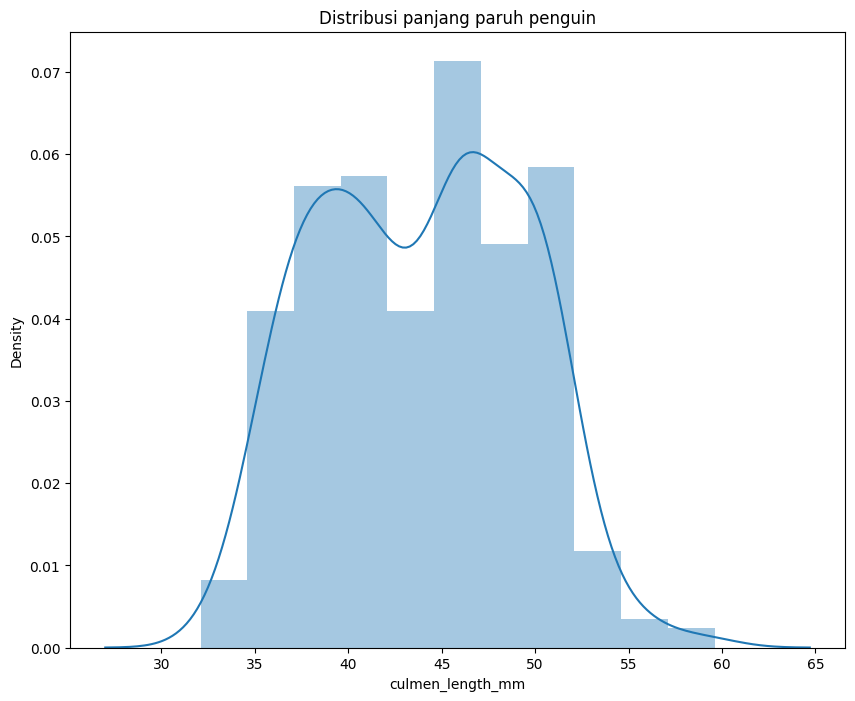

In [12]:
# Visualisasi kolom bill length
plt.figure(figsize=(10, 8))
sns.distplot(df["culmen_length_mm"])
plt.title("Distribusi panjang paruh penguin")
plt.show()

kolom culmen_length_mm tampaknya sudah aman dan tidak ada skewness ya dari datanya. Kita akan lanjut dengan melihat kedalaman paruhnya.

<ipython-input-13-b3d2226d0db1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["culmen_depth_mm"])


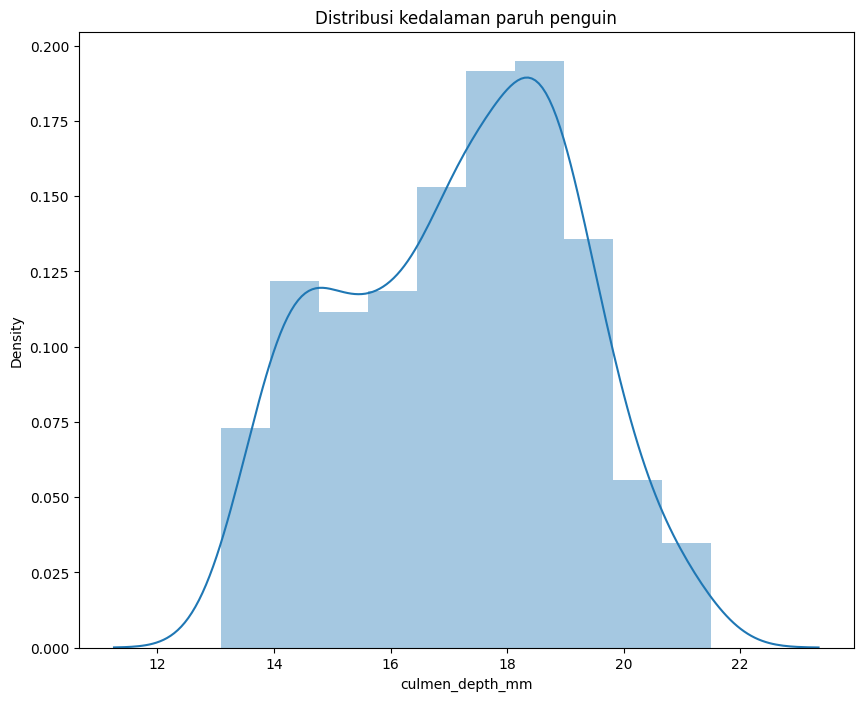

In [13]:
plt.figure(figsize=(10, 8))
sns.distplot(df["culmen_depth_mm"])
plt.title("Distribusi kedalaman paruh penguin")
plt.show()

Sama seperti sebelumnya, kolom ini juga aman.

<Axes: xlabel='culmen_length_mm', ylabel='culmen_depth_mm'>

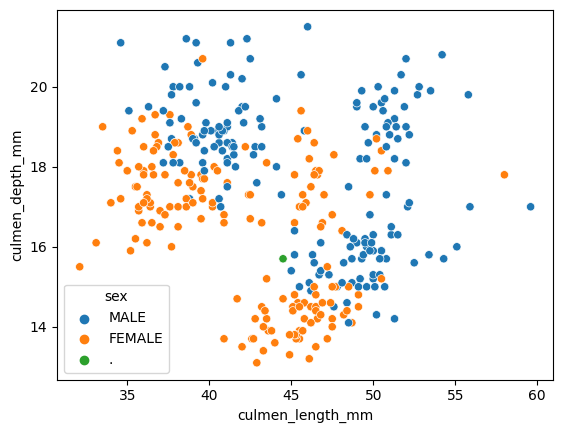

In [14]:
sns.scatterplot(x='culmen_length_mm', y='culmen_depth_mm', hue = 'sex', data=df)

hmmm....tampaknya data sex ini memiliki satu nilai unique yang tidak kita inginkan, yaitu ".", perlu dicatat tampilan diatas menunjukkan kolerasi antara kolom panjang paruh dan kedalaman paruh penguin. Bisa dilihat penguin gender male cenderung memiliki paruh yang lebih panjang dan lebih dalam dibandingkan paruh penguin female.

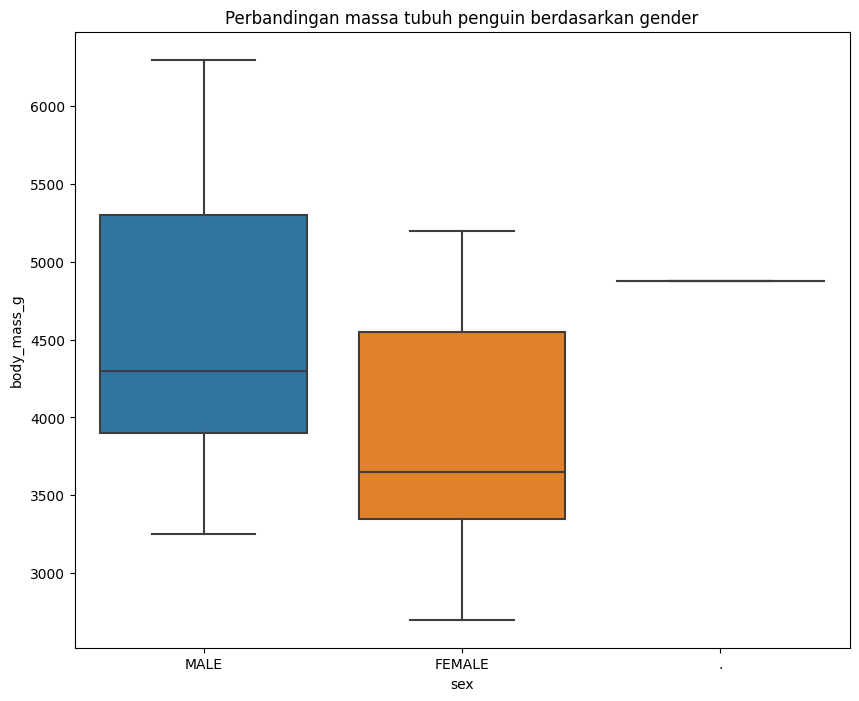

In [15]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="sex", y="body_mass_g", data=df)
plt.title("Perbandingan massa tubuh penguin berdasarkan gender")
plt.show()

Bisa dilihat dari box plot diatas, terdapat data yang tidak masuk akal karena nilainya yang terlalu tinggi dan terlalu rendah, ini yang dinamakan nilai outlier, karena didalam datasetsnya terdapat data outlier, kita harus menghilangkan itu terlebih dahulu agar visualisasi selanjutnya terlihat lebih rapih dan sesuai.

In [16]:
print(df[df["flipper_length_mm"] > 4000])
print(df[df["flipper_length_mm"] < 0])

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g   sex
9              42.0             20.2             5000.0       4250.0  MALE
    culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g   sex
14              34.6             21.1             -132.0       4400.0  MALE


Nah, bisa kita lihat, terdapat 2 baris data yang memiliki nilai flipper tidak masuk akal, yaitu 5000 dan -132, maka harus kita hilangkan agar tidak terjadi keabnormalan untuk proses selanjutnya.

In [17]:
df_no = df.drop([9, 14])

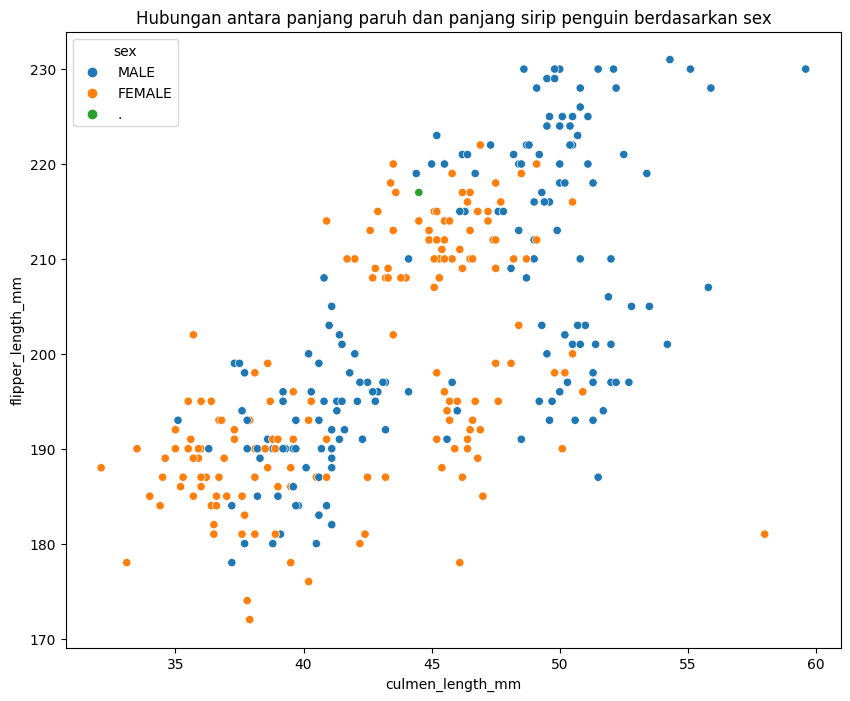

In [18]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="culmen_length_mm", y="flipper_length_mm", hue='sex', data=df_no)
plt.title("Hubungan antara panjang paruh dan panjang sirip penguin berdasarkan sex")
plt.show()

Pada plot scatter diatas menunjukkan bahwa panjang paruh penguin dan flippernya memiliki hubungan based on gender penguin tersebut.

#Preprocessing

Karena tadi kita menemukan data null pada datasets dan terdapat nilai '.' pada kolom sex, mari kita hilangkan nilai-nilai tersebut.

In [19]:
df_clean = df_no.dropna()
df_clean = df_clean[df_clean['sex'] != '.']
df_clean

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
4,36.7,19.3,193.0,3450.0,FEMALE
5,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,FEMALE
340,46.8,14.3,215.0,4850.0,FEMALE
341,50.4,15.7,222.0,5750.0,MALE
342,45.2,14.8,212.0,5200.0,FEMALE


Lalu kita harus melihat ulang apakah datasetsnya masih memiliki nilai null dan kita harus reset_indexnya agar saat modeling tidak terdapat cluster yang nyasar (tidak sesuai dengan barisnya).

In [23]:
df_clean.isnull().sum()
df_clean = df_clean.reset_index(drop=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   sex                332 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


Mari periksa ulang grafik perbandingan antara sex dan body_mass_g

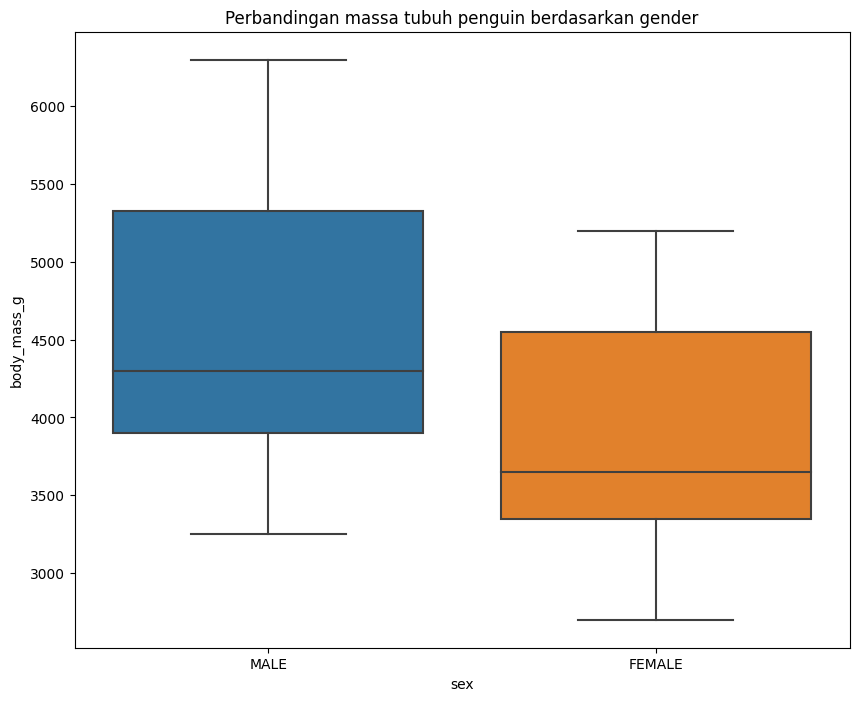

In [24]:
plt.figure(figsize=(10, 8))
sns.boxplot(x="sex", y="body_mass_g", data=df_clean)
plt.title("Perbandingan massa tubuh penguin berdasarkan gender")
plt.show()

mulai sekarang data yang akan kita gunakan berada pada variable df_clean.

Karena kita akan menggunakan kolom sex, kita akan mengubahnya menjadi nilai 1 untuk male dan 0 untuk female.

In [25]:
df_clean["sex"] = df_clean["sex"].replace({"MALE": 1, "FEMALE": 0})

In [26]:
df_clean

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,36.7,19.3,193.0,3450.0,0
4,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...
327,47.2,13.7,214.0,4925.0,0
328,46.8,14.3,215.0,4850.0,0
329,50.4,15.7,222.0,5750.0,1
330,45.2,14.8,212.0,5200.0,0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

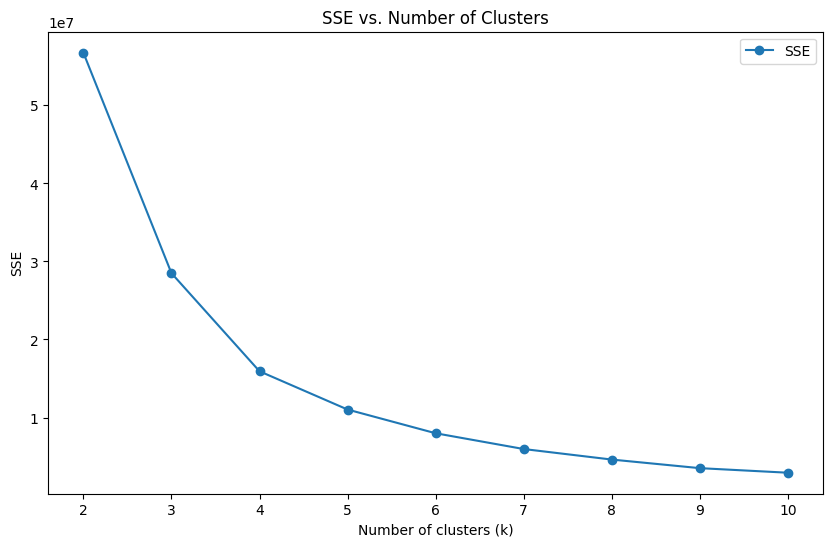

In [27]:
features = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g", "sex"]
data = df_clean[features]
sse_scores = []
k_range = range(2, 11)  # Adjust k range based on your data

for k in k_range:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data)
  sse_scores.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse_scores, marker="o", label="SSE")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.title("SSE vs. Number of Clusters")
plt.legend()

disini kita akan ambil 5 sebagai K nya karena perubahan SSE dari 5 ke 6 tidak begitu steep

#Modeling

Kita akan melakukan tahap modeling disini dengan menggunakan 5 jumlah cluster. Lalu memasukkan label hasil modeling ke dalam variable labels. Serta menunjukkan nilai tengah masing-masing cluster.

In [28]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_clean)
labels = pd.DataFrame(kmeans.labels_)
kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kita memasukkan nilai labels kedalam dataframe kita dengan membuat kolom baru bernama Labels

In [29]:
df_clean['Labels'] = labels

In [32]:
df_clean.head(-5)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,Labels
0,39.1,18.7,181.0,3750.0,1,1
1,39.5,17.4,186.0,3800.0,0,1
2,40.3,18.0,195.0,3250.0,0,3
3,36.7,19.3,193.0,3450.0,0,3
4,39.3,20.6,190.0,3650.0,1,1
...,...,...,...,...,...,...
322,43.5,15.2,213.0,4650.0,0,0
323,51.5,16.3,230.0,5500.0,1,2
324,46.2,14.1,217.0,4375.0,0,4
325,55.1,16.0,230.0,5850.0,1,2


Sip, sudah sesuai. selanjutnya adalah melakukan visualisasi clustering agar bisa melihat hasilnya dengan lebih jelas

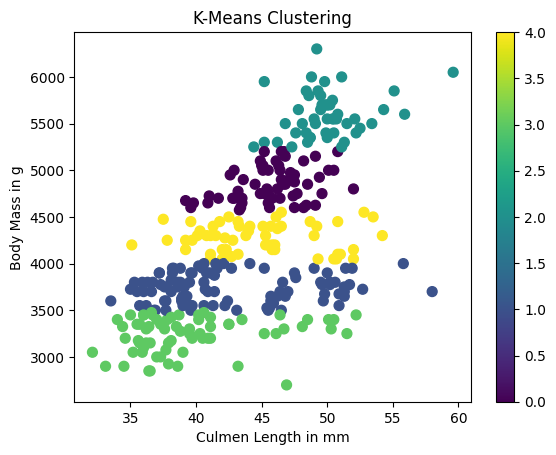

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_clean['culmen_length_mm'],df_clean['body_mass_g'],c=labels,s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Culmen Length in mm')
ax.set_ylabel('Body Mass in g')
plt.colorbar(scatter)

Diatas merupakan hasil clustering yang menunjukkan panjang paruh penguin dengan berat badannya.

#Save Model

In [34]:
with open("model_penguin.pkl", "wb") as f:
    pickle.dump(kmeans, f)